screenshot size: (1600, 2560)
左侧边栏区域 xywh：(14, 86, 81, 962)


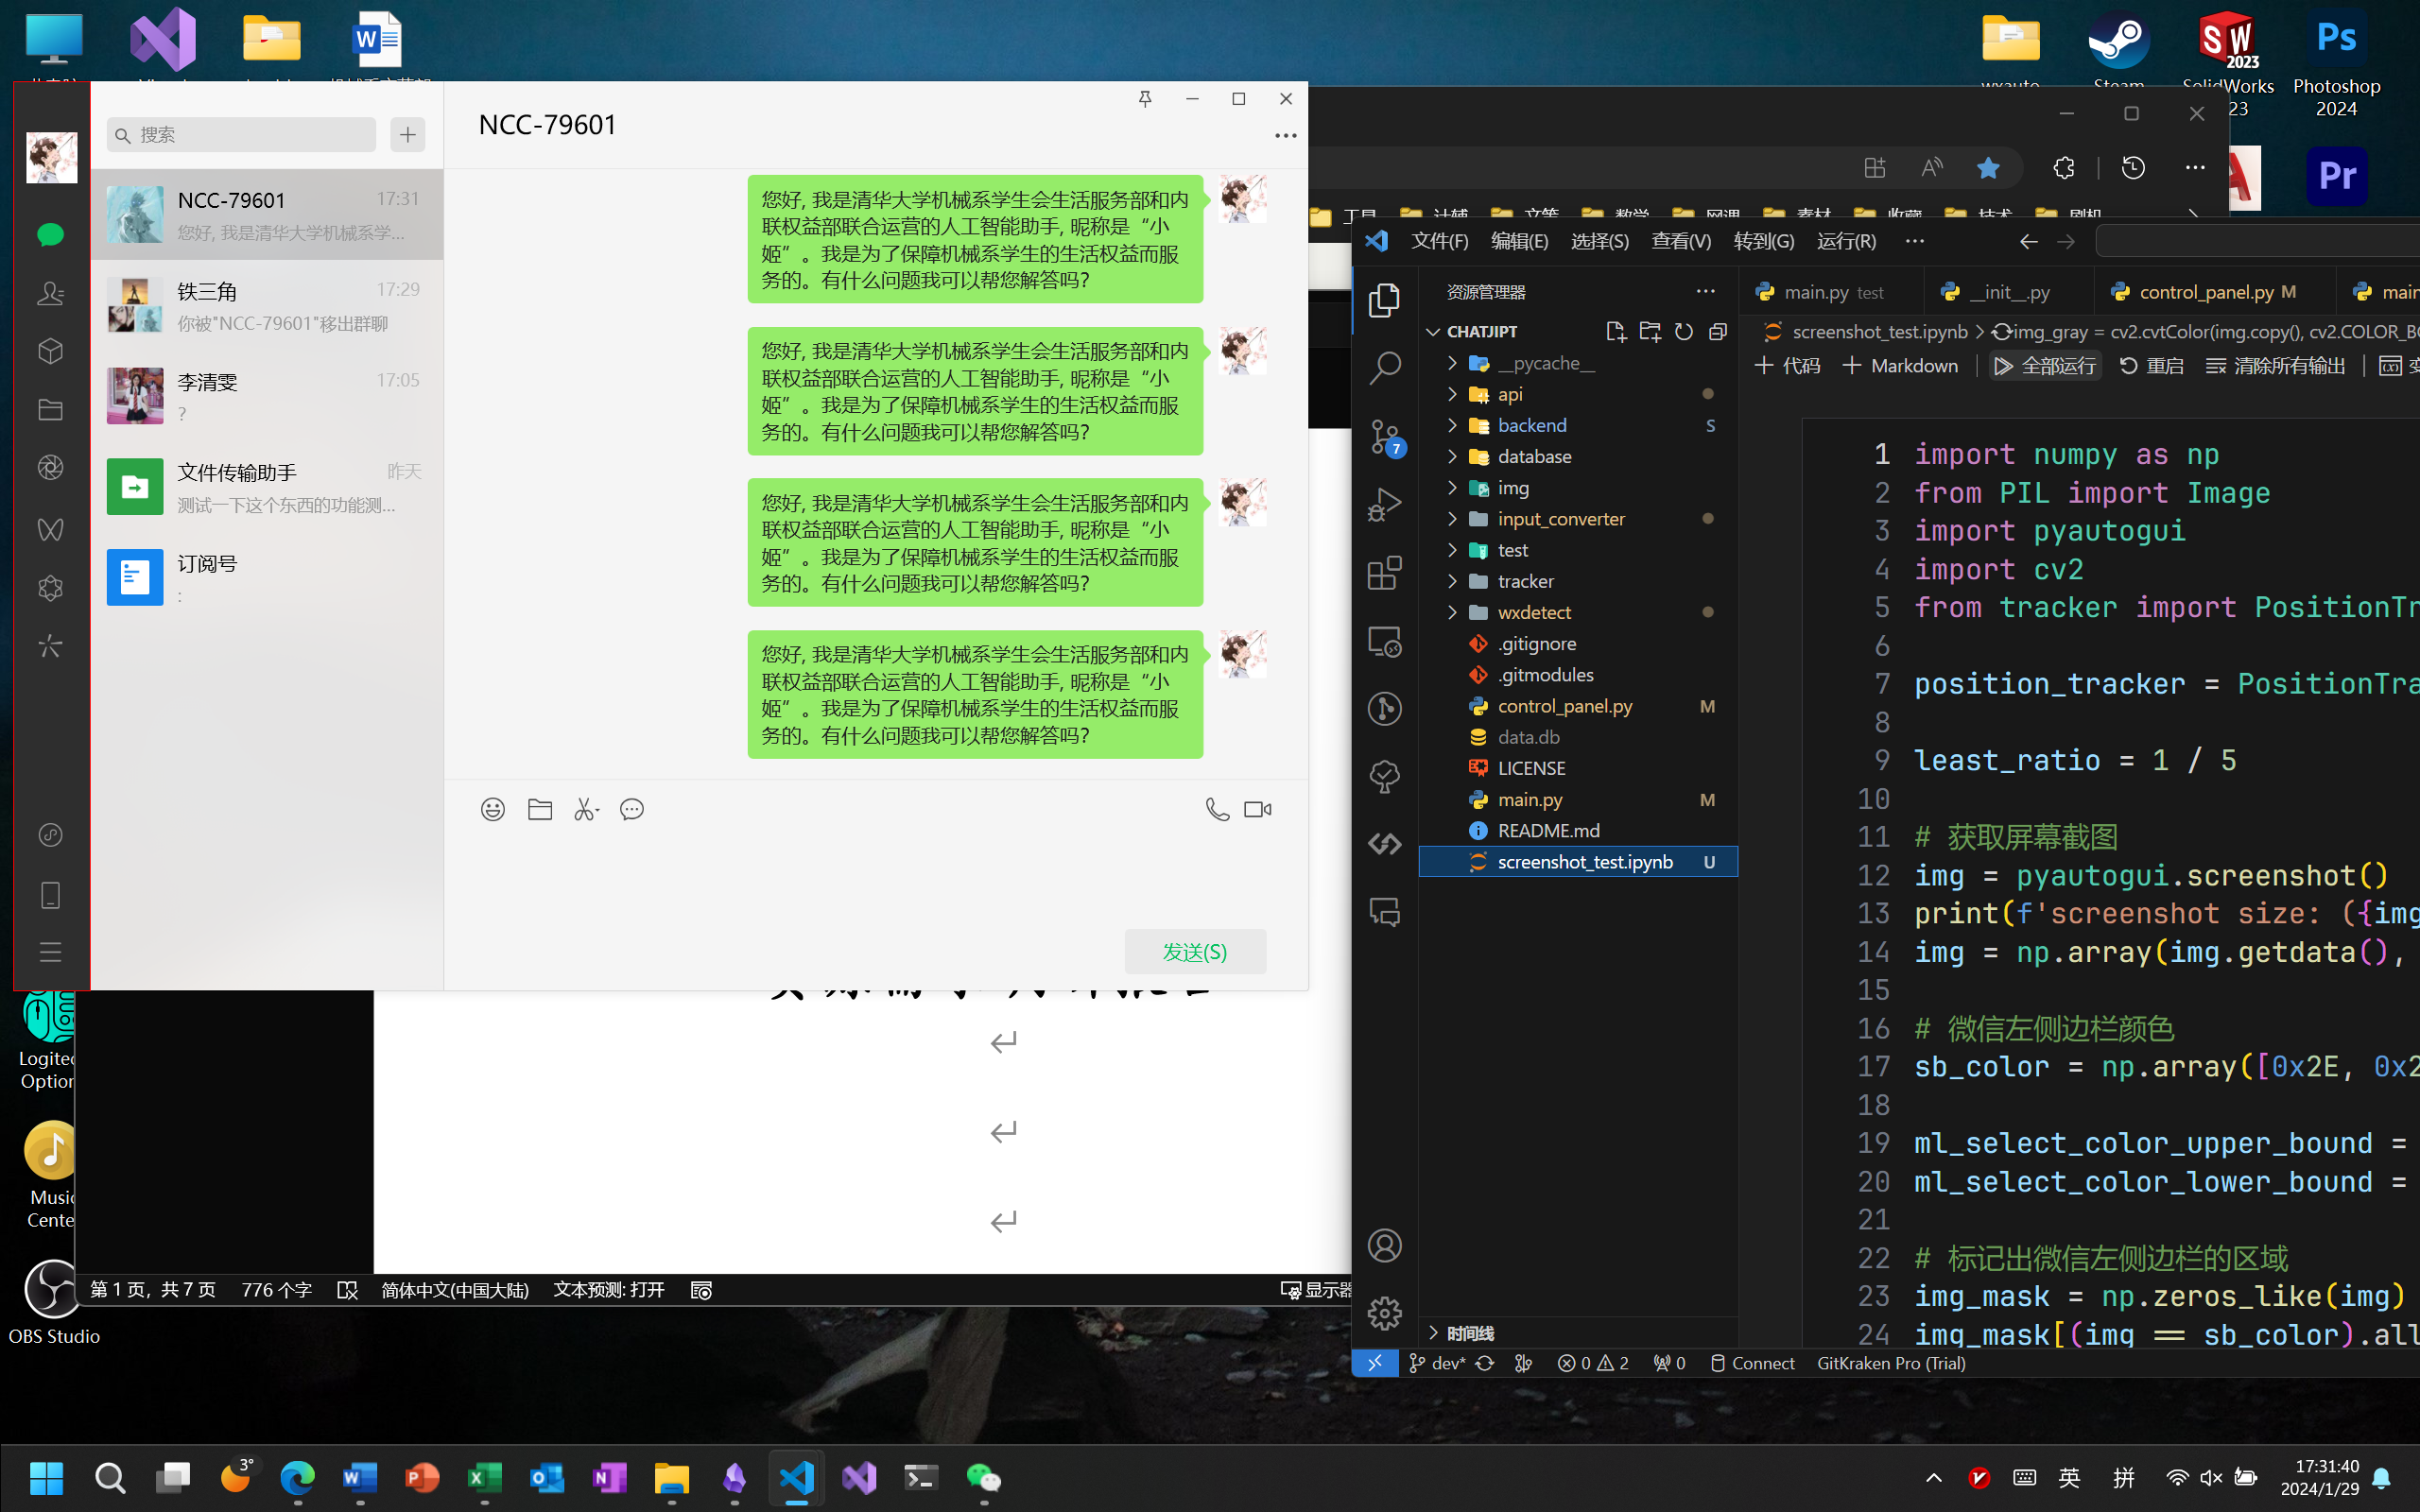

In [53]:
import numpy as np
from PIL import Image
import pyautogui
import cv2
from tracker import PositionTracker

position_tracker = PositionTracker()

least_ratio = 1 / 5

# 获取屏幕截图
img = pyautogui.screenshot()
print(f'screenshot size: ({img.size[1]}, {img.size[0]})')
img = np.array(img.getdata(), np.uint8).reshape(img.size[1], img.size[0], 3)

# 微信左侧边栏颜色
sb_color = np.array([0x2E, 0x2E, 0x2E])

ml_select_color_upper_bound = np.array([0xC9,0xC9, 0xC9])
ml_select_color_lower_bound = np.array([0xC4,0xC4, 0xC4])

# 标记出微信左侧边栏的区域
img_mask = np.zeros_like(img)
img_mask[(img == sb_color).all(axis=-1)] = [255, 255, 255]

gray_img = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
sb_x, sb_y, sb_w, sb_h = cv2.boundingRect(largest_contour)

position_tracker.add_ref("window_origin", sb_x, sb_y)

print(f'左侧边栏区域 xywh：({sb_x}, {sb_y}, {sb_w}, {sb_h})')

marked_img = img
cv2.rectangle(marked_img, \
              (sb_x, sb_y), \
              (sb_x + sb_w, sb_y + sb_h), \
              (255, 0, 0), thickness=1)

Image.fromarray(marked_img)

消息列表 xywh：(96, 179, 373, 96)
消息列表数量：9


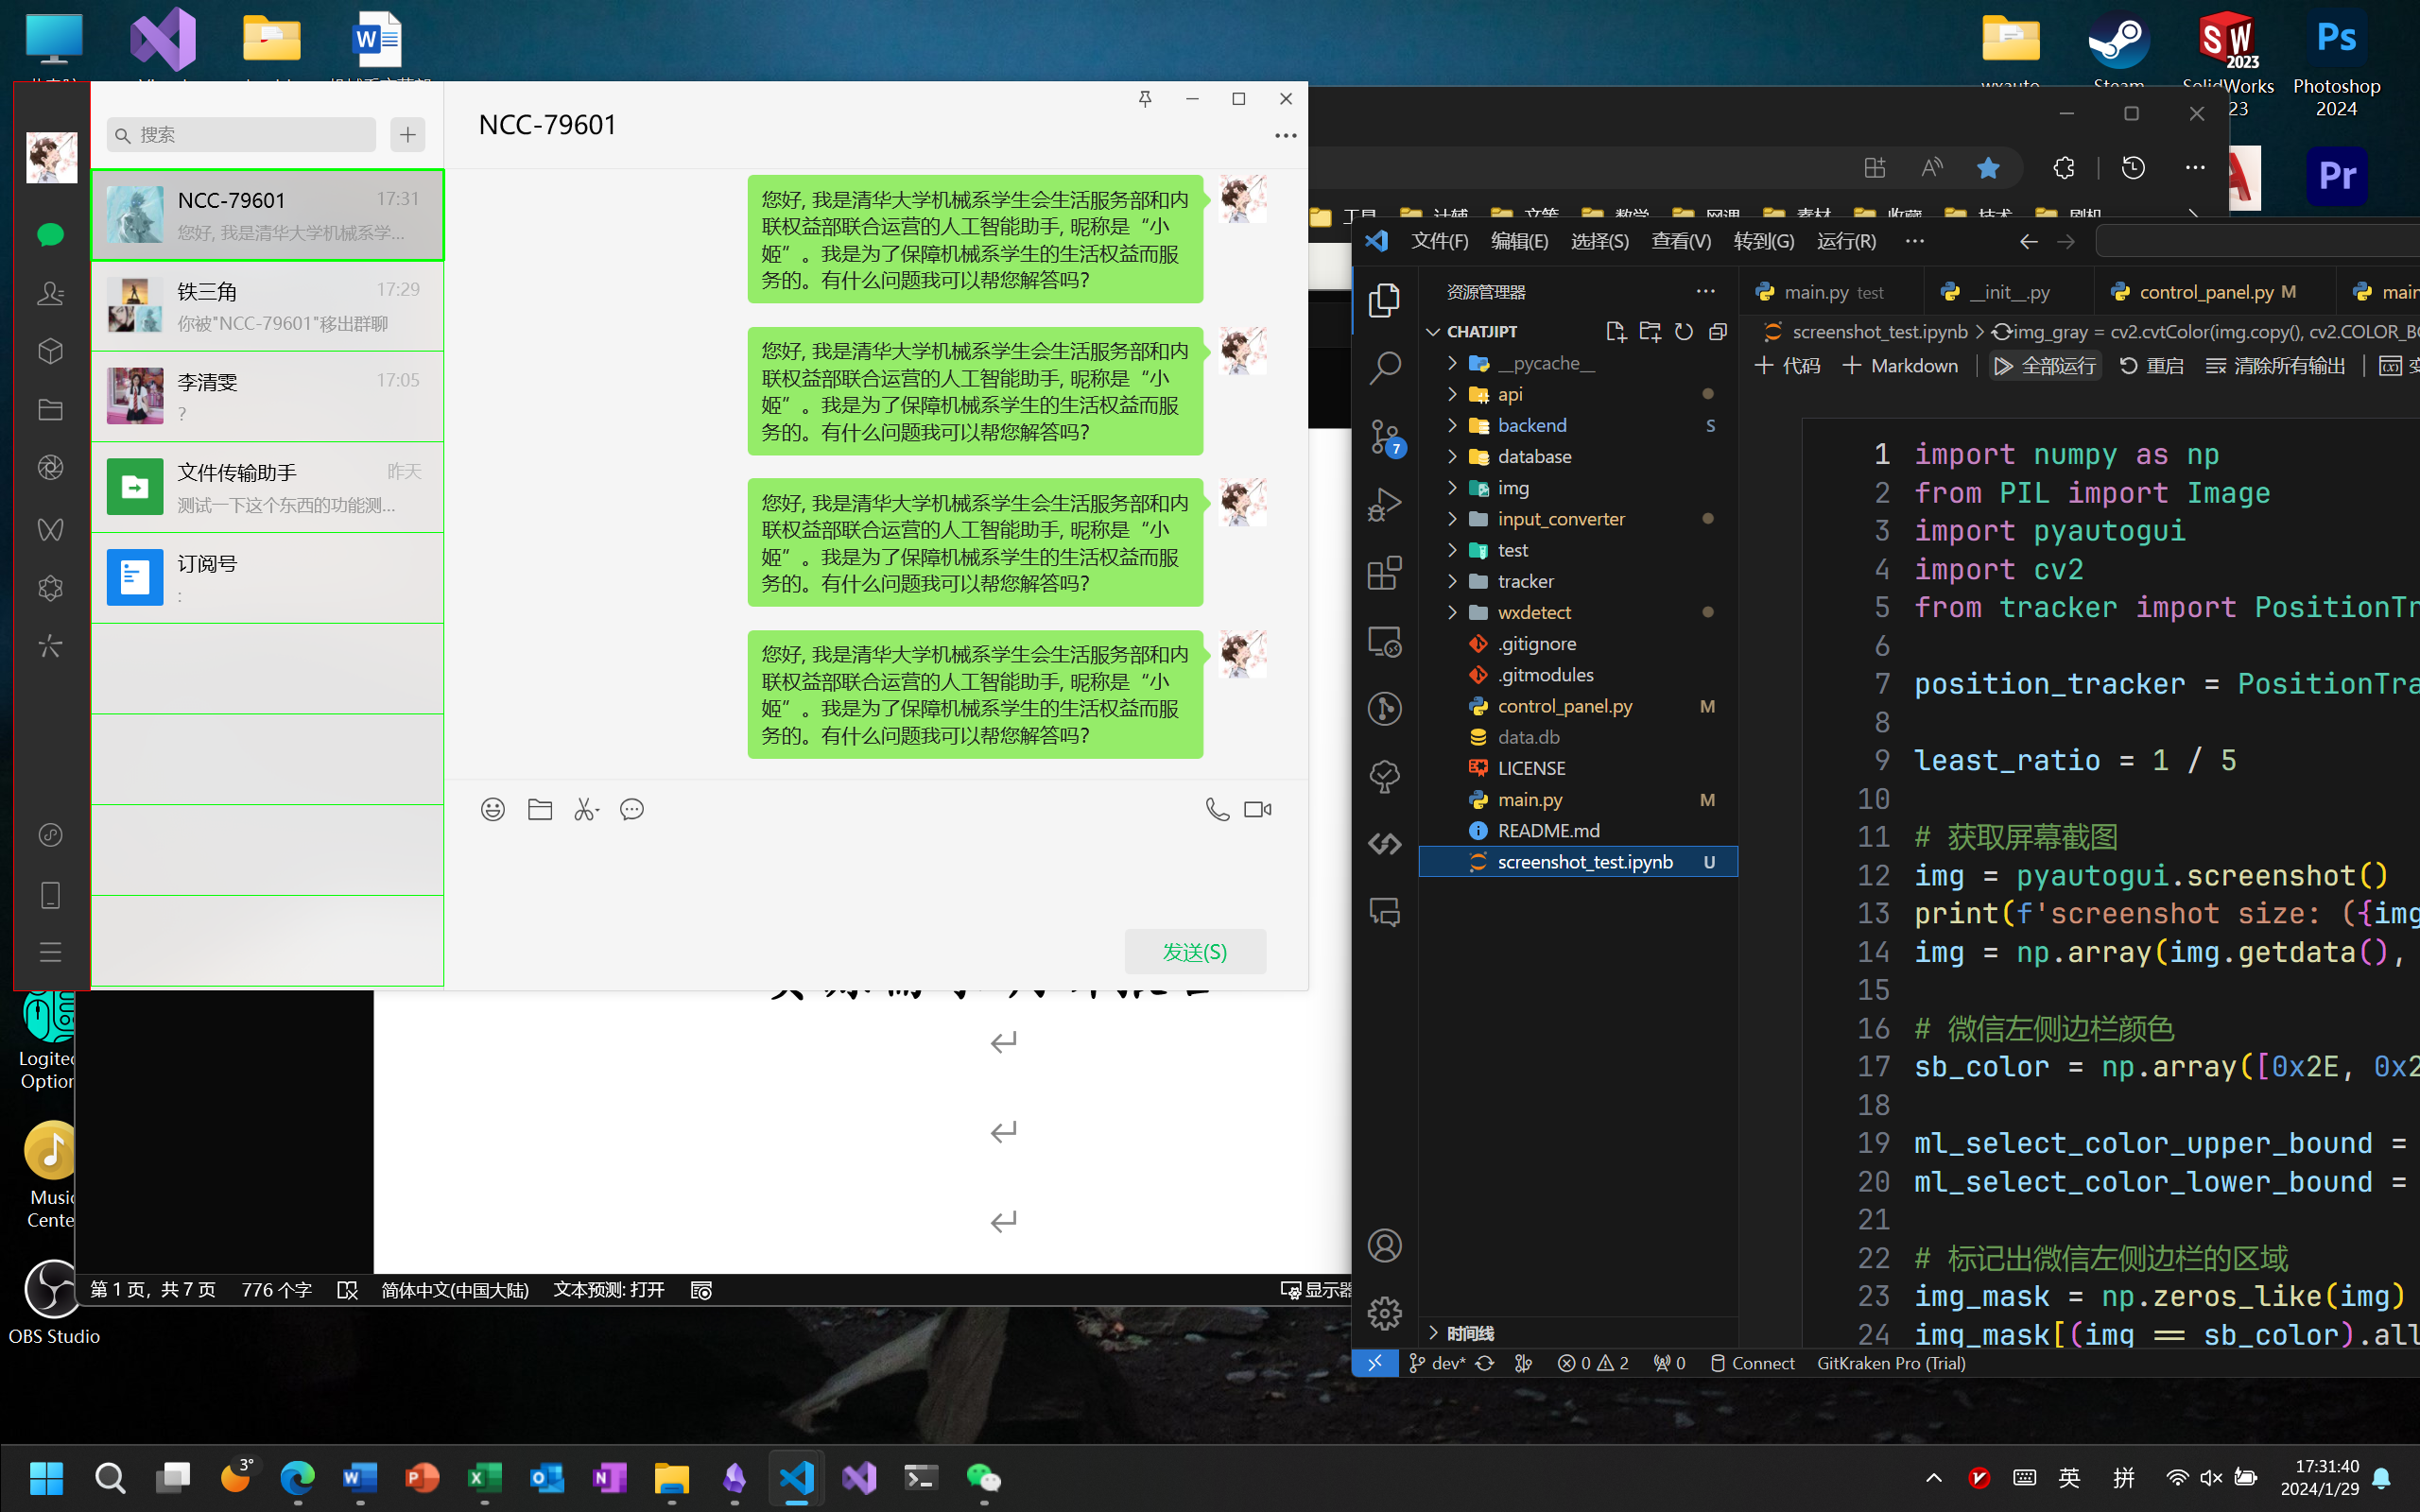

In [54]:
# 标记出选中的聊天窗口
img_mask = np.zeros_like(img)
img_mask[(img >= ml_select_color_lower_bound).all(axis=-1) & (img <= ml_select_color_upper_bound).all(axis=-1)] = [255, 255, 255]

gray_img = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
ml_select_x, ml_select_y, ml_select_w, ml_select_h = cv2.boundingRect(largest_contour)

ml_select_y_new = int(sb_w / 54 * 61) + sb_y
ml_select_index = int((ml_select_y - ml_select_y_new) / ml_select_h)
ml_y_bias = (ml_select_y - ml_select_y_new) % ml_select_h
ml_select_y = ml_select_y_new + ml_y_bias


print(f'消息列表 xywh：({ml_select_x}, {ml_select_y}, {ml_select_w}, {ml_select_h})')

marked_img = img

msglist_num = (sb_y + sb_h - ml_select_y) // ml_select_h
print(f'消息列表数量：{msglist_num}')

msglist_rois = []
for i in range(msglist_num):
    if ml_select_y + (i + 1) * ml_select_h > sb_y + sb_h:
        break
    msglist_rois.append((ml_select_x, ml_select_y + i * ml_select_h, ml_select_w, ml_select_h))

position_tracker.add_ref("msglist_origin", *msglist_rois[0][0:2])

for i in range(msglist_num):
    roi = msglist_rois[i]
    if (i == ml_select_index):
        cv2.rectangle(marked_img, \
                  (roi[0], roi[1]), \
                  (roi[0] + roi[2], roi[1] + roi[3]), \
                  (0, 255, 0), thickness=2)
    else:
        cv2.rectangle(marked_img, \
                  (roi[0], roi[1]), \
                  (roi[0] + roi[2], roi[1] + roi[3]), \
                  (0, 255, 0), thickness=1)

Image.fromarray(marked_img)

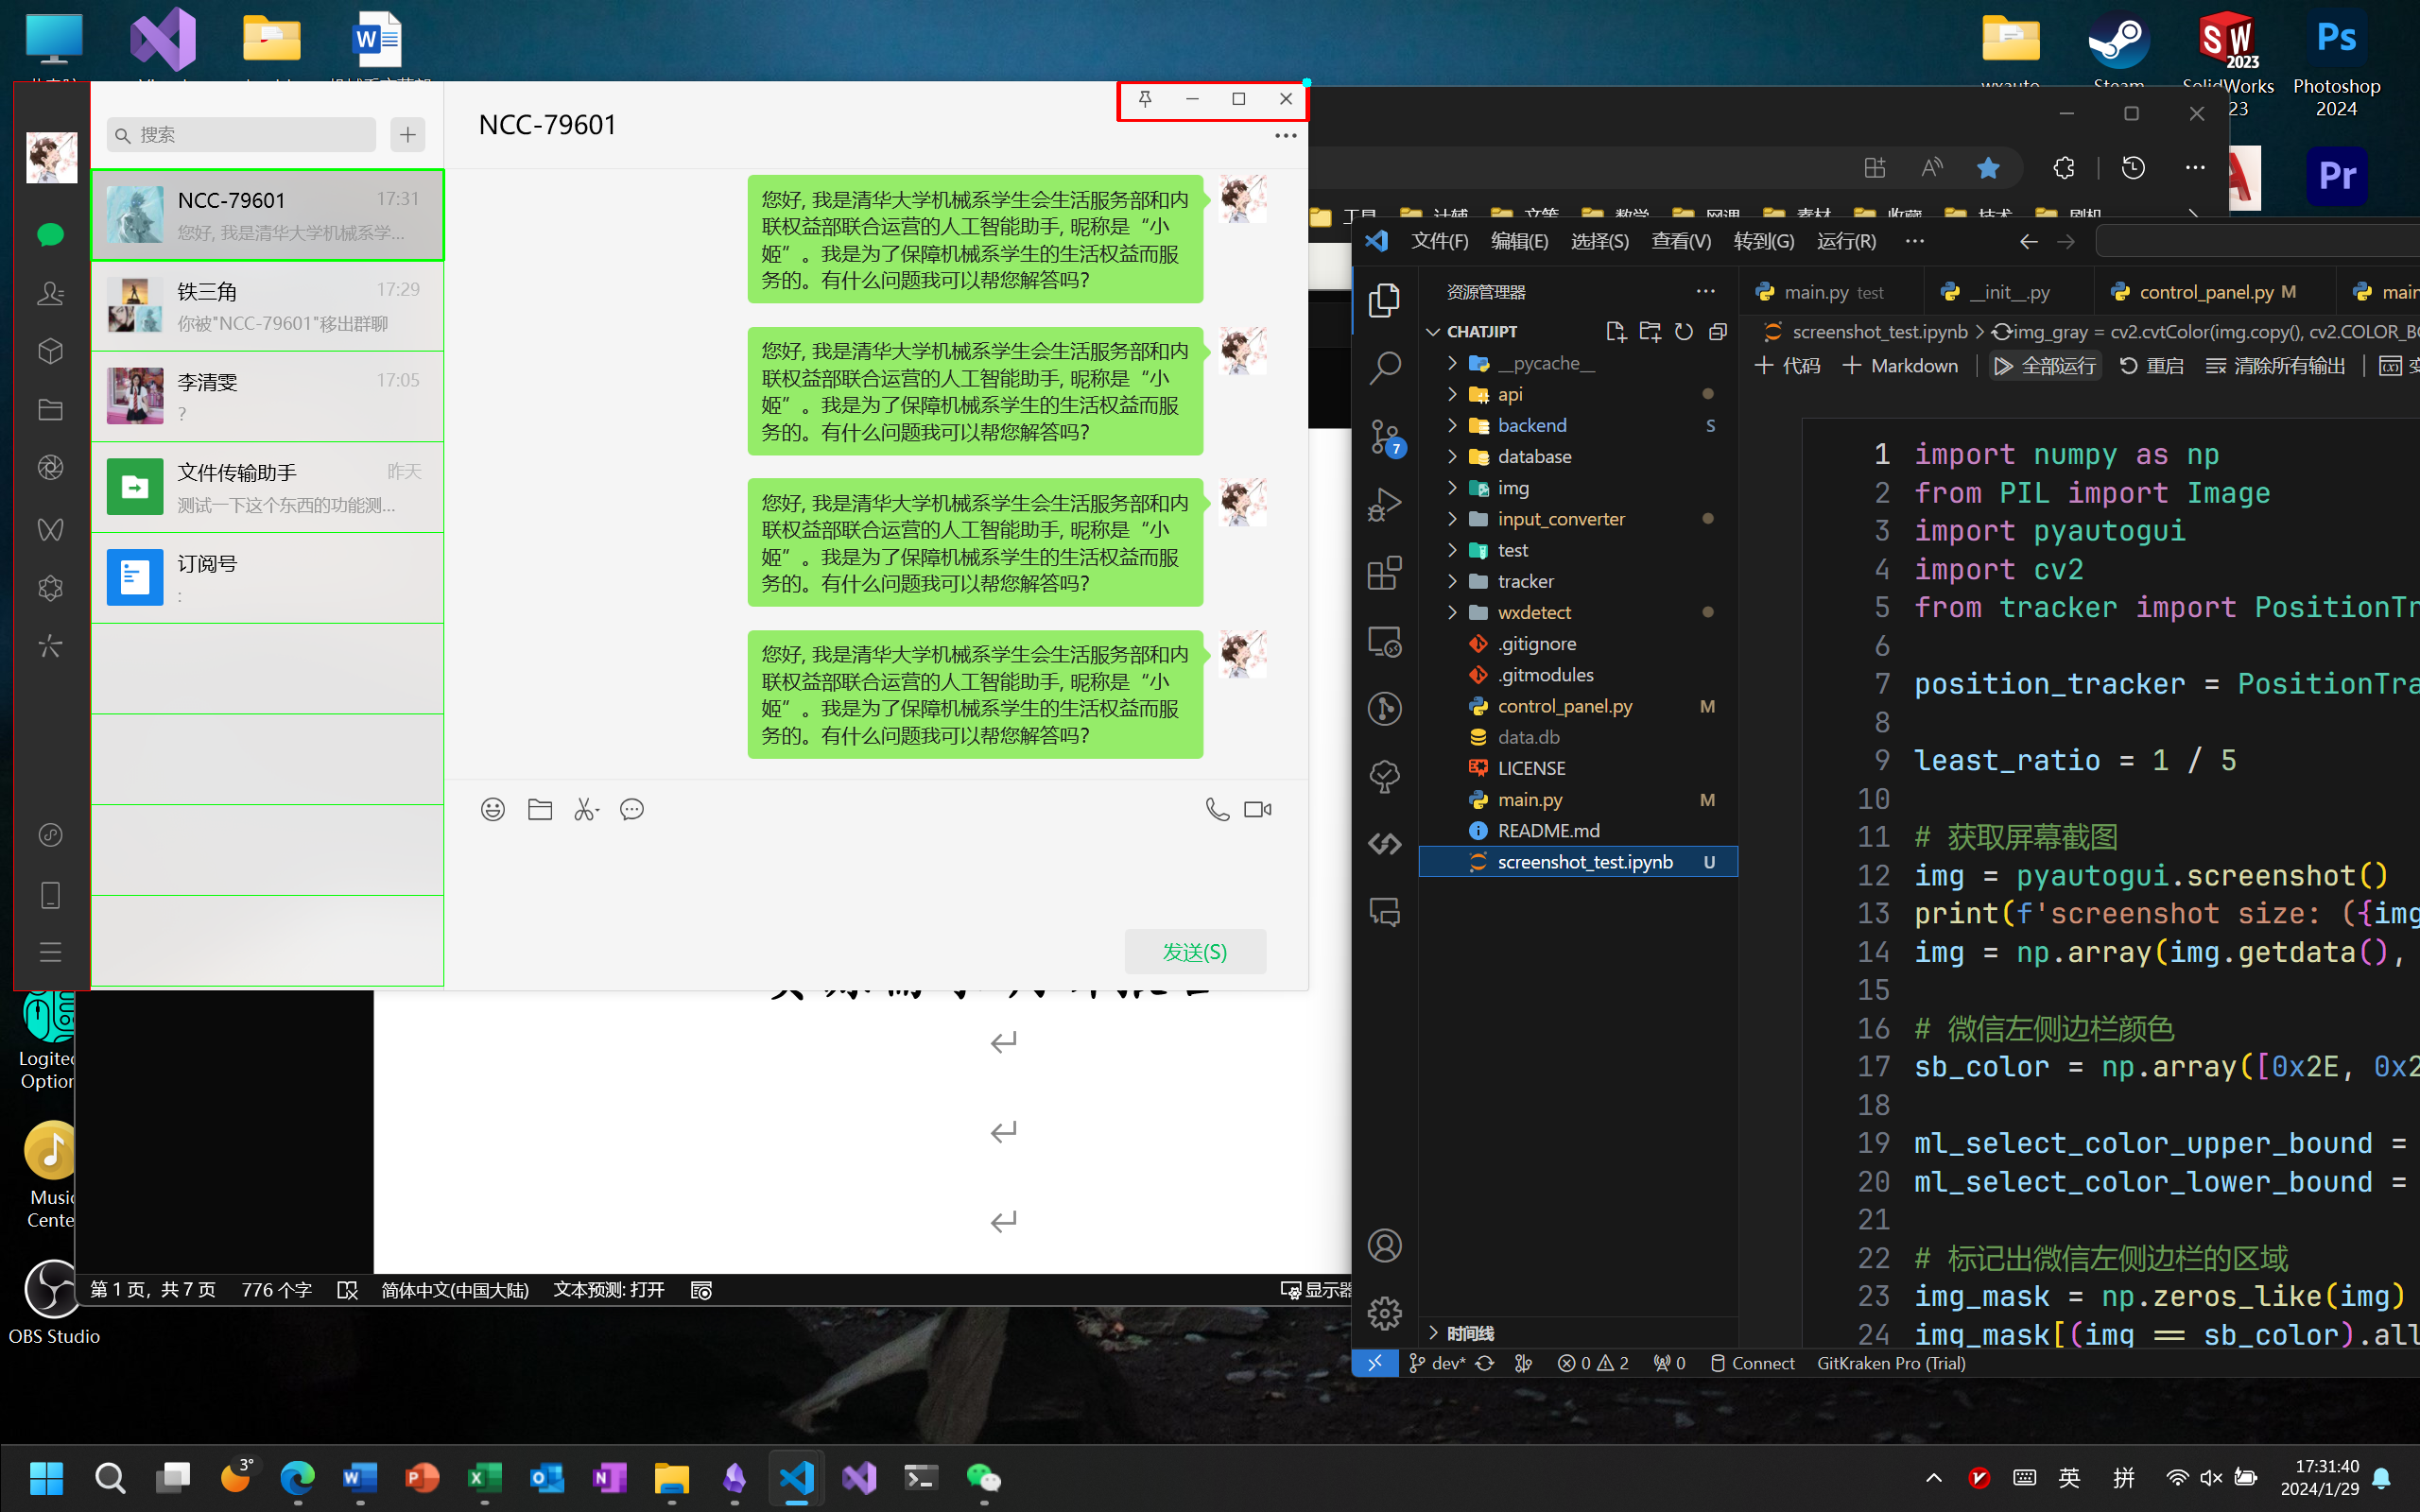

In [55]:
img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)       
img_pyramid = [img_gray]
# for i in range(2):
    # img_pyramid.append(cv2.pyrDown(img_pyramid[-1]))

# 加载微信右上角四大金刚按钮的照片 (1080p, 1440p)，进行模式识别
templates = []
templates.append(cv2.imread('./wxdetect/pattern/top_right_pattern_1080p.png', 0))
templates.append(cv2.imread('./wxdetect/pattern/top_right_pattern_1440p.png', 0))

rt_xywh = None

for template in templates:

    w, h = template.shape[::-1]

    # 创建模式图像金字塔，以 0.5 的比例逐级缩小
    template_pyramid = [template]
    for i in range(2):
        template_pyramid.append(cv2.pyrDown(template_pyramid[-1]))

    # 逐级进行模式识别
    for i, (p, t) in enumerate(zip(img_pyramid, template_pyramid)):
        res = cv2.matchTemplate(p, t, cv2.TM_CCOEFF_NORMED)
        threshold = 0.7
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            scale = 2 ** i
            # 画出识别到的区域
            if rt_xywh == None:
                rt_xywh = (pt[0]*scale, pt[1]*scale, w*scale, h*scale)
            cv2.rectangle(marked_img, (pt[0]*scale, pt[1]*scale), ((pt[0] + w)*scale, (pt[1] + h)*scale), (255, 0, 0), 2)
    
    if rt_xywh != None:
        break

if rt_xywh == None:
    print('未寻找到微信右上角四大金刚按钮，退出')
    exit(1)

rt_x = rt_xywh[0] + rt_xywh[2]
rt_y = rt_xywh[1] # + rt_xywh[3]
cv2.circle(marked_img, (rt_x, rt_y), radius=5, color=(0, 255, 255), thickness=-1)

from wxdetect.wxwindow import WXWindow

wx = WXWindow(x=sb_x, y=sb_y, w=rt_x-sb_x, h=sb_h)
# wx.draw_boundary(marked_img)

Image.fromarray(marked_img)

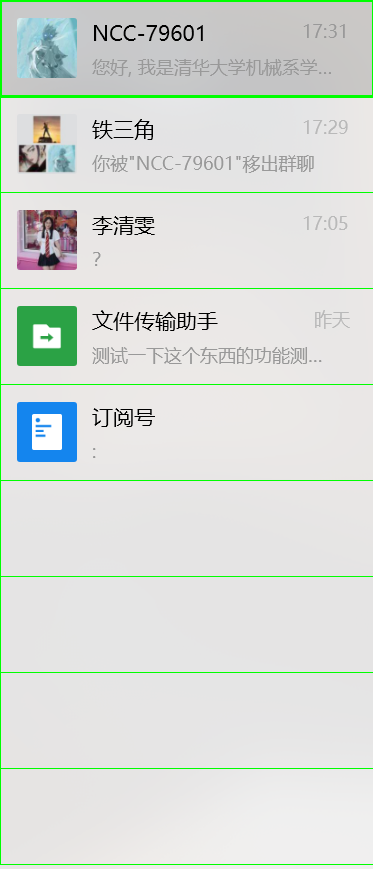

In [56]:
msglist_img = img[msglist_rois[0][1]:sb_y+sb_h, ml_select_x:ml_select_x+ml_select_w]
Image.fromarray(msglist_img)

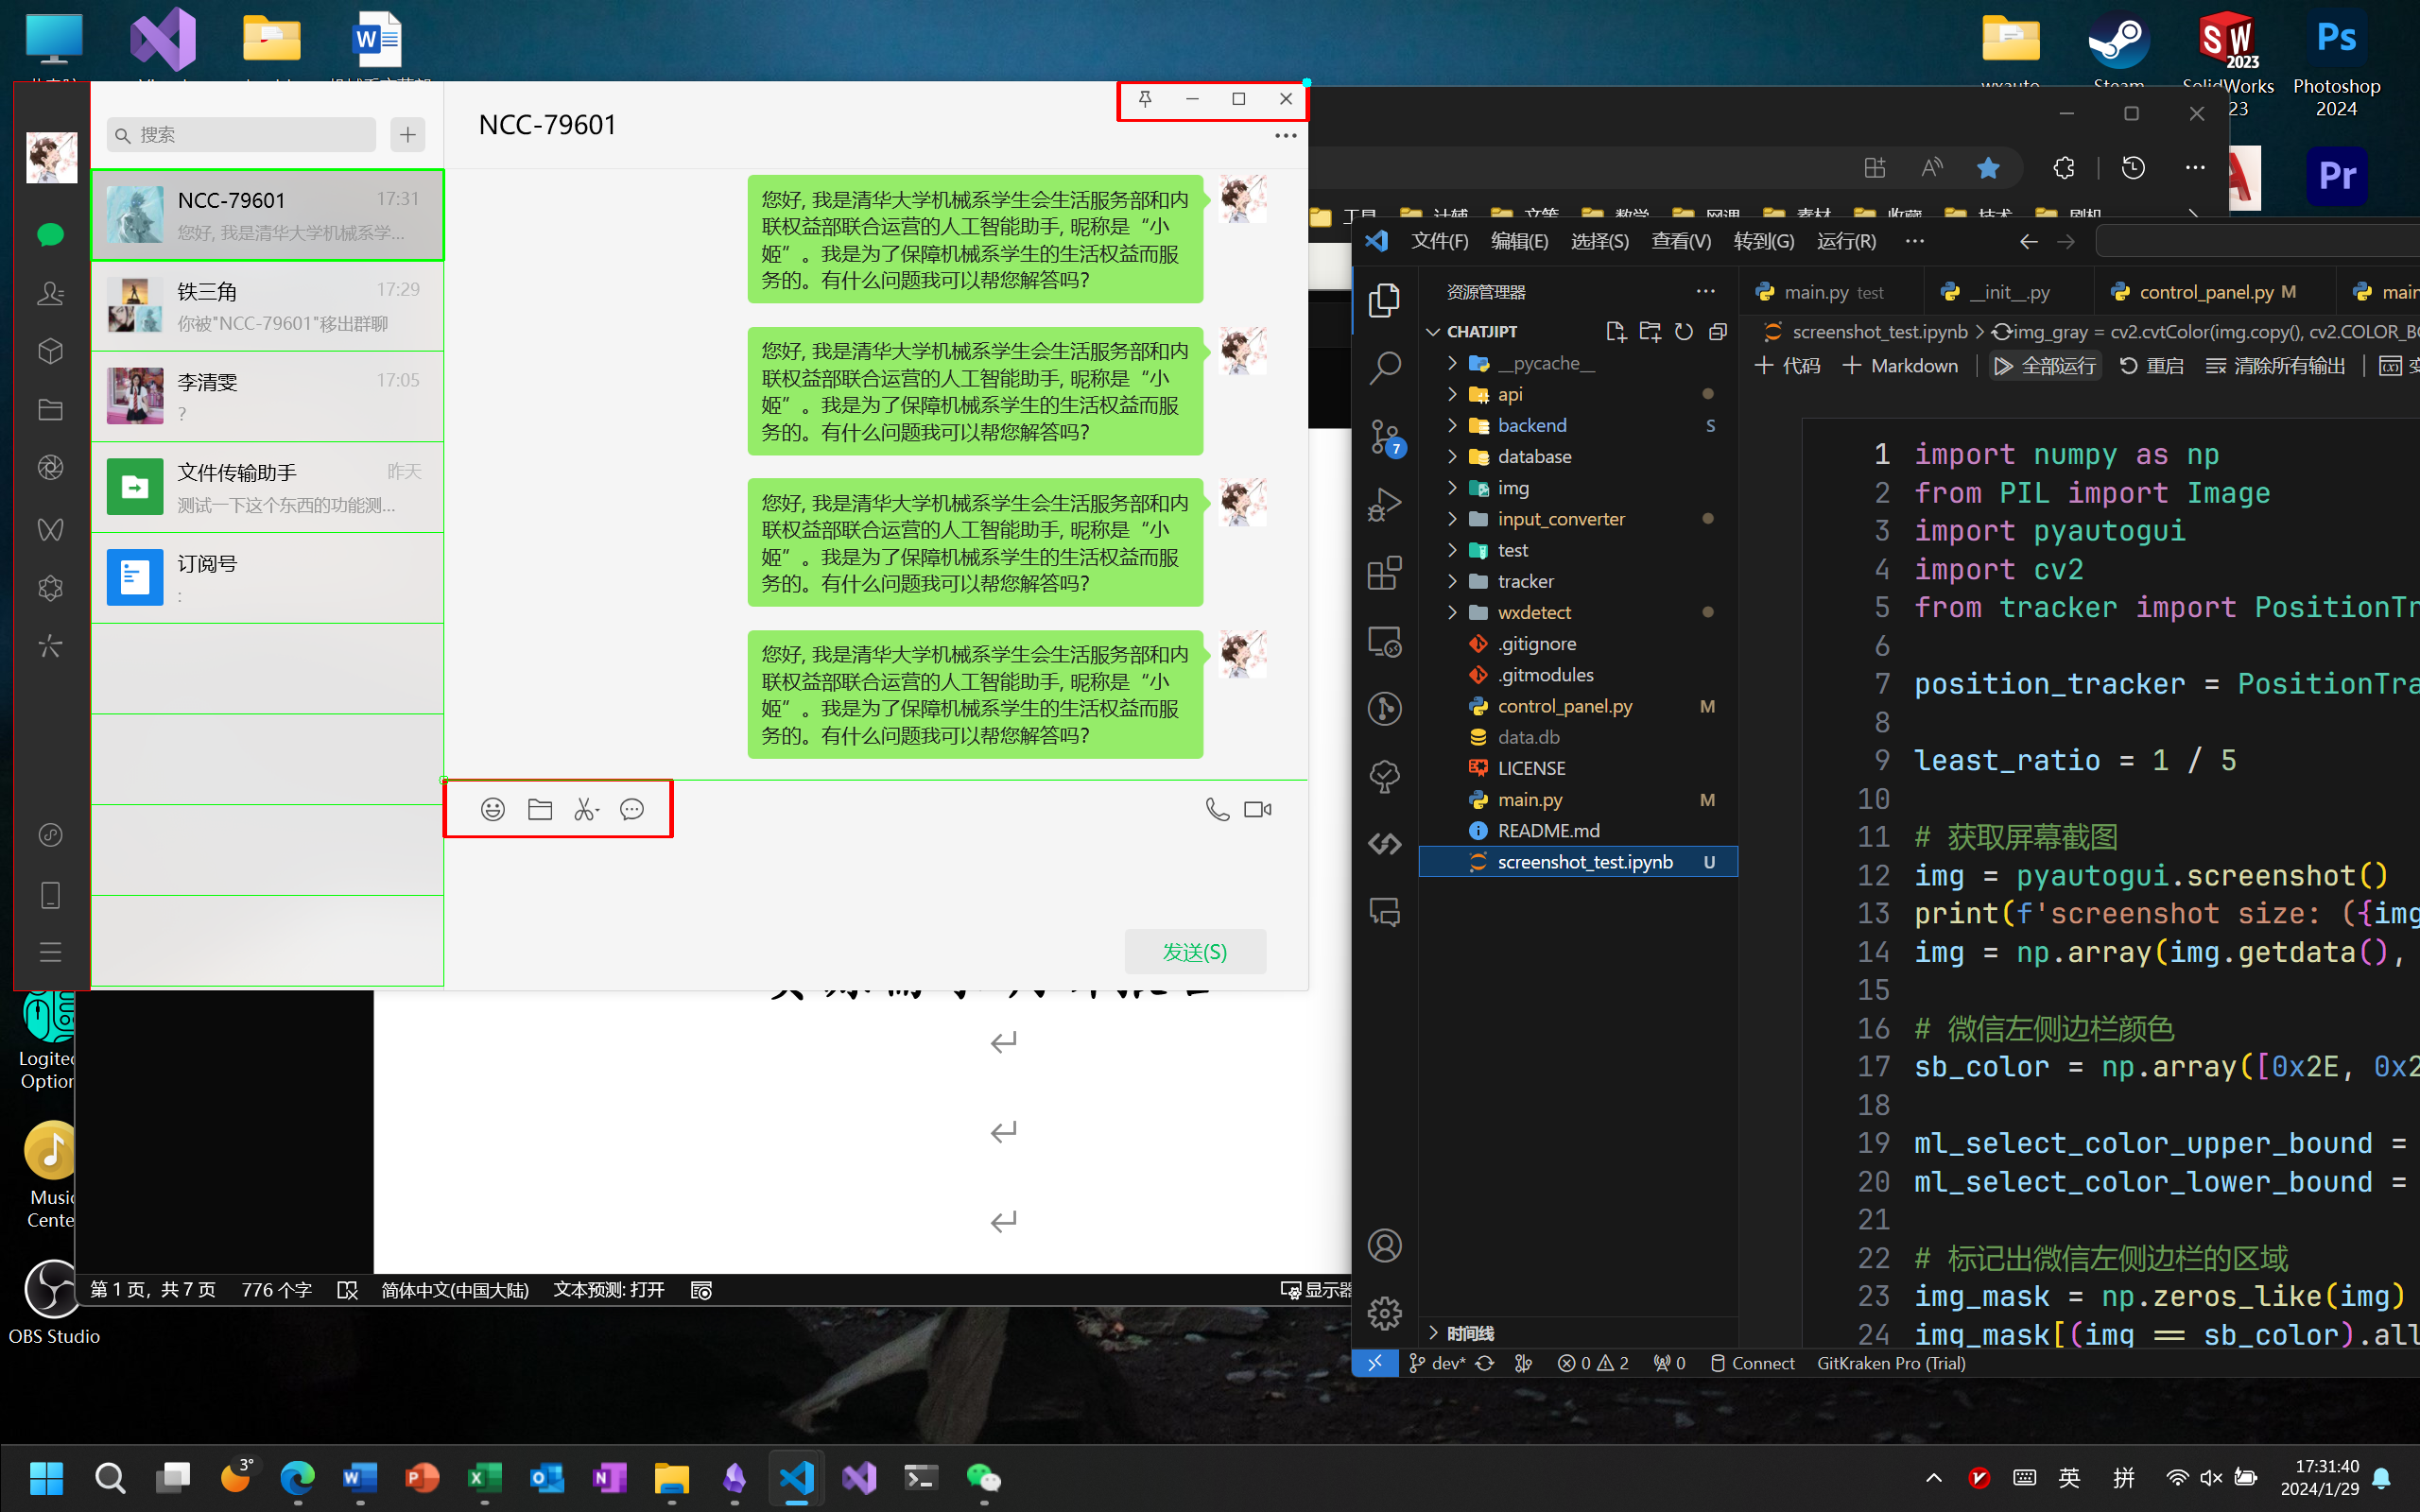

In [57]:
# 加载 chatbox 工具栏的照片 (1080p, 1440p)，进行模式识别
templates = []
templates.append(cv2.imread('./wxdetect/pattern/chatbox_toolbar_1080p.png', 0))
templates.append(cv2.imread('./wxdetect/pattern/chatbox_toolbar_1440p.png', 0))

cb_tb_xywh = None

for template in templates:

    w, h = template.shape[::-1]

    # 创建模式图像金字塔，以 0.5 的比例逐级缩小
    template_pyramid = [template]
    for i in range(2):
        template_pyramid.append(cv2.pyrDown(template_pyramid[-1]))

    # 逐级进行模式识别
    for i, (p, t) in enumerate(zip(img_pyramid, template_pyramid)):
        res = cv2.matchTemplate(p, t, cv2.TM_CCOEFF_NORMED)
        threshold = 0.7
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            scale = 2 ** i
            # 画出识别到的区域
            if cb_tb_xywh == None:
                cb_tb_xywh = (pt[0]*scale, pt[1]*scale, w*scale, h*scale)
            cv2.rectangle(marked_img, (pt[0]*scale, pt[1]*scale), ((pt[0] + w)*scale, (pt[1] + h)*scale), (255, 0, 0), 2)
    
    if cb_tb_xywh != None:
        break

cb_tb_x = cb_tb_xywh[0]
cb_tb_y = cb_tb_xywh[1]
cb_w = wx.x + wx.w - cb_tb_x

position_tracker.add_ref("chatbox_inputbox_origin", cb_tb_x, cb_tb_y)

cv2.circle(marked_img, (cb_tb_x, cb_tb_y), radius=5, color=(0, 255, 0), thickness=1)
cv2.line(marked_img, (cb_tb_x, cb_tb_y), (cb_tb_x + cb_w, cb_tb_y), (0, 255, 0), thickness=1)

Image.fromarray(marked_img)

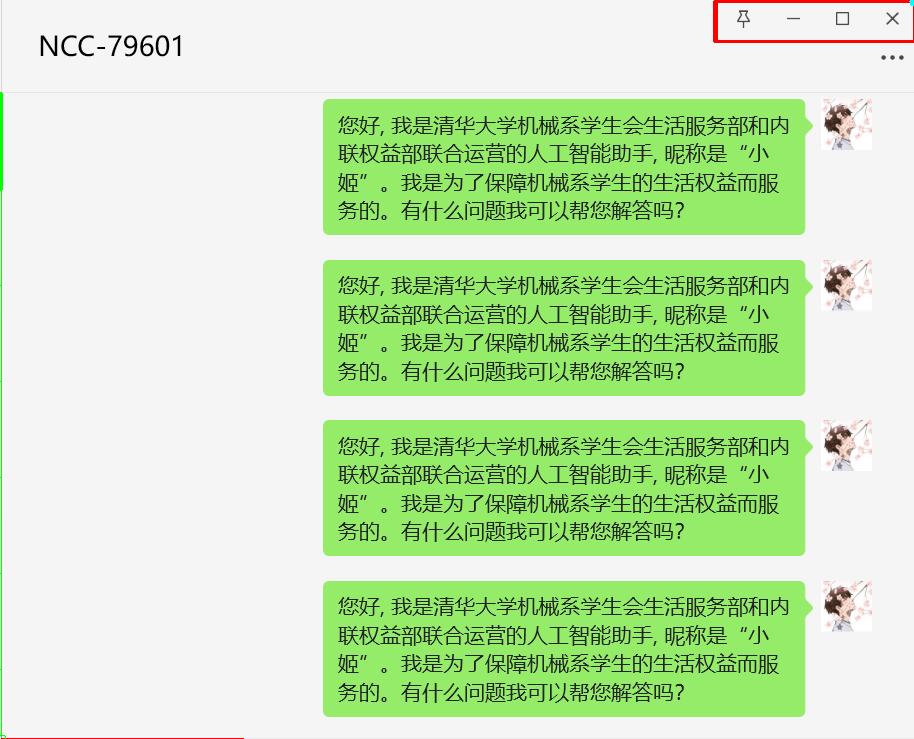

In [58]:
window_img = img[wx.y:wx.y+wx.h, wx.x:wx.x+wx.w].copy()

l_bound = sb_w + ml_select_w
b_bound = sb_h - (wx.y + wx.h - cb_tb_y)

chatbox_img = window_img[:b_bound, l_bound:]

Image.fromarray(chatbox_img)

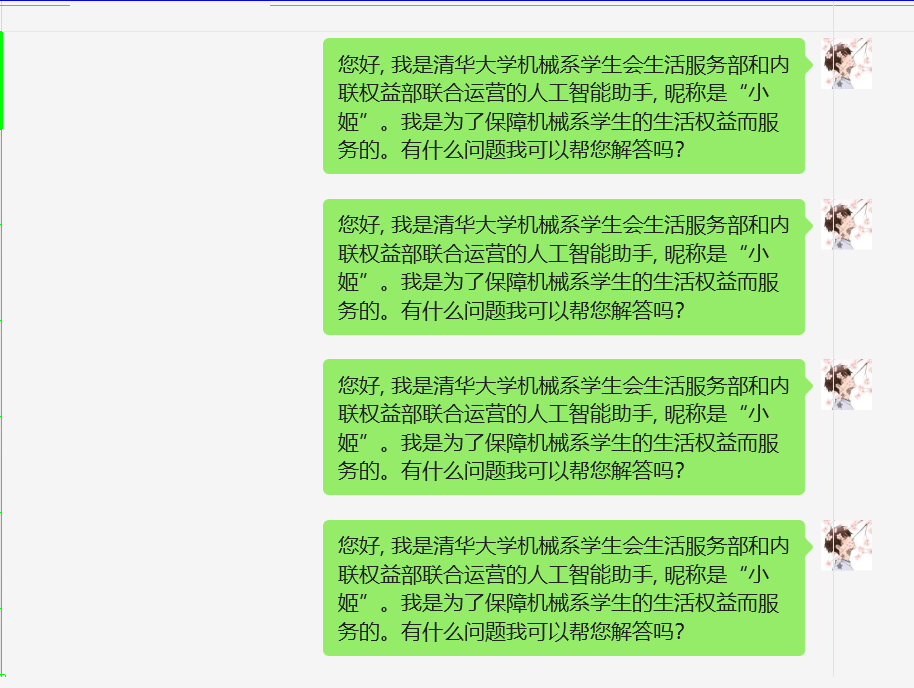

In [68]:
last_msg_from_me_detect_x = chatbox_img.shape[1] - 1 - (34 + 30 + 10 + 5)
msg_from_me_color = np.array([0x95, 0xEC, 0x69])
last_msg_from_me_detect_y = 61

# cv2.line(chatbox_img, (last_msg_from_me_detect_x - 1, 0), (last_msg_from_me_detect_x - 1, chatbox_img.shape[0]), (255, 255, 0), thickness=1)

for i in range(chatbox_img.shape[0] - 1, 60-1, -1):
    if (chatbox_img[i, last_msg_from_me_detect_x] == msg_from_me_color).all():
        last_msg_from_me_detect_y = i
        print(f'detected: {last_msg_from_me_detect_y}')
        break
cv2.line(chatbox_img, (0, last_msg_from_me_detect_y), (chatbox_img.shape[1], last_msg_from_me_detect_y), (0, 0, 255), thickness=1)

chatbox_content_roi = chatbox_img[last_msg_from_me_detect_y:, :]
chatbox_content_roi[-1, :] = [0xF5, 0xF5, 0xF5]
pad = int(max(10, chatbox_content_roi.shape[1] * least_ratio - chatbox_content_roi.shape[0]))
chatbox_content_roi = np.concatenate((chatbox_content_roi, np.full((pad, chatbox_content_roi.shape[1], 3), 0xF5, dtype=np.uint8)), axis=0)

Image.fromarray(chatbox_content_roi)

detected: 91


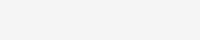

In [60]:
last_msg_from_ta_detect_x = 1 + (34 + 30 + 10 + 5)
msg_from_ta_color = np.array([0xF5, 0xF5, 0xF5])
last_msg_from_ta_detect_y = 61

# cv2.line(chatbox_img, (last_msg_from_ta_detect_x + 1, 0), (last_msg_from_ta_detect_x + 1, chatbox_img.shape[0]), (255, 255, 0), thickness=1)

precolor = msg_from_ta_color
detect_cnt = 0

for i in range(chatbox_img.shape[0] - 1, 60-1, -1):
    if (chatbox_img[i, last_msg_from_ta_detect_x] != precolor).all():
        detect_cnt += 1
        precolor = chatbox_img[i, last_msg_from_ta_detect_x]

    if detect_cnt == 2:
        last_msg_from_ta_detect_y = i
        print(f'detected: {last_msg_from_ta_detect_y}')
        break

if last_msg_from_ta_detect_y > 61 + 25:
    last_msg_from_ta_detect_y -= 25

cv2.line(chatbox_img, (0, last_msg_from_ta_detect_y), (chatbox_img.shape[1], last_msg_from_ta_detect_y), (0, 255, 0), thickness=1)
Image.fromarray(chatbox_img)

name_roi = (last_msg_from_ta_detect_y, 70, 24, 200)
name_img = chatbox_img[name_roi[0]:name_roi[0]+name_roi[2], name_roi[1]:name_roi[1]+name_roi[3]]
name_img[0:1, ...] = [0xF5, 0xF5, 0xF5]
pad = int(max(10, name_img.shape[1] * least_ratio - name_img.shape[0]))
padding = np.ones((pad, name_img.shape[1], name_img.shape[2]), dtype=np.uint8) * 0xF5
name_img = np.concatenate((name_img, padding), axis=0)
Image.fromarray(name_img)

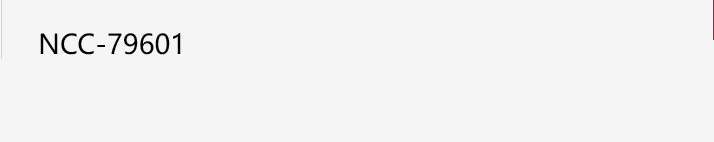

In [61]:
chatbox_title_roi = chatbox_img[2:61, :-200]
pad = int(max(10, chatbox_title_roi.shape[1] * least_ratio - chatbox_title_roi.shape[0]))
padding = np.ones((pad, chatbox_title_roi.shape[1], chatbox_title_roi.shape[2]), dtype=np.uint8) * 0xF5
chatbox_title_roi = np.concatenate((chatbox_title_roi, padding), axis=0)
Image.fromarray(chatbox_title_roi)

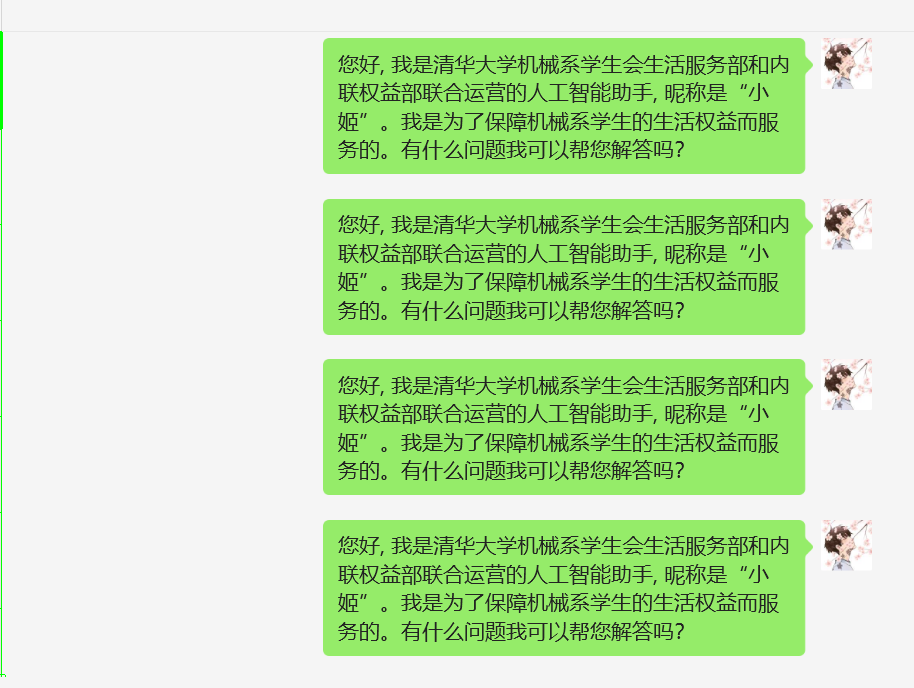

In [62]:
Image.fromarray(chatbox_content_roi)

In [63]:
from rapidocr_onnxruntime import RapidOCR

engine = RapidOCR()  # Initialize RapidOCR
title_ocr_result = engine(chatbox_title_roi)  # Perform OCR on the image
content_ocr_result = engine(chatbox_content_roi)
nickname_ocr_result = engine(name_img)

def judge_empty(ocr_result):
    if ocr_result == None or ocr_result[0] == None or len(ocr_result[0]) == 0:
        return True
    return False

if judge_empty(nickname_ocr_result):
    print(f'-> 未检测到昵称，判断为单聊')
    is_group_chat = False
else:
    print(f'-> 检测到昵称，判断为群聊')
    is_group_chat = True

for line in title_ocr_result[0]:
    print(line[1])

import re
def is_time_format(s):
    return bool(re.match(r'^\d{1,2}:\d{2}$', s))

new_msg_content = ""

if judge_empty(content_ocr_result):
    print(f'-> 未检测到新消息')
else:
    for line in content_ocr_result[0]:
        if line[1] == '以下是新消息' or is_time_format(line[1]):
            continue
        new_msg_content += line[1]

print("-"*5, "新消息内容", "-"*5)
print(new_msg_content)

-> 未检测到昵称，判断为单聊
NCC-79601
----- 新消息内容 -----
您好，我是清华大学机械系学生会生活服务部和内联权益部联合运营的人工智能助手，昵称是“小姬”。我是为了保障机械系学生的生活权益而服务的。有什么问题我可以帮您解答吗？您好，我是清华大学机械系学生会生活服务部和内联权益部联合运营的人工智能助手，呢称是“小姬”。我是为了保障机械系学生的生活权益而服务的。有什么问题我可以帮您解答吗？您好，我是清华大学机械系学生会生活服务部和内联权益部联合运营的人工智能助手，昵称是“小姬”。我是为了保障机械系学生的生活权益而服务的。有什么问题我可以帮您解答吗？您好，我是清华大学机械系学生会生活服务部和内联权益部联合运营的人工智能助手，昵称是“小姬”。我是为了保障机械系学生的生活权益而服务的。有什么问题我可以帮您解答吗？


unread_bubbles: None


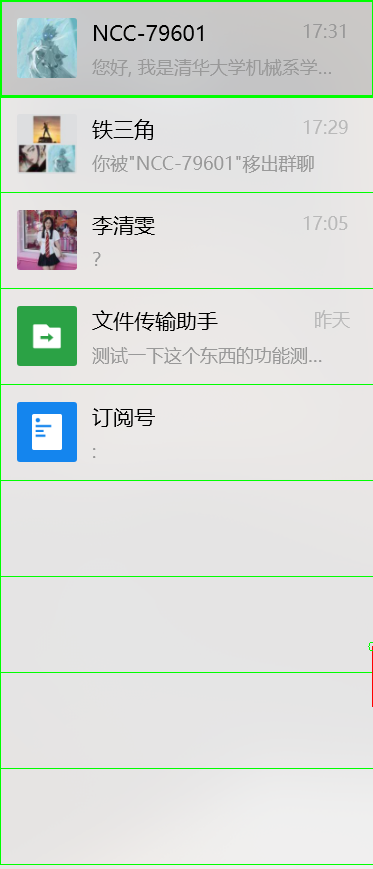

In [64]:
# 定义颜色范围（这里是红色，可以根据需要进行调整）
lower_red = np.uint8([0xFA, 0x51, 0x51])
upper_red = np.uint8([0xFA, 0x51, 0x51])

# 创建掩模
mask = cv2.inRange(msglist_img, lower_red, upper_red)
mask = cv2.dilate(mask, None, iterations=2)
mask = cv2.erode(mask, None, iterations=2)

Image.fromarray(mask)

# Hough 变换检测圆形
unread_bubbles = cv2.HoughCircles(
    mask,                   # 输入图像
    cv2.HOUGH_GRADIENT,     # 使用基于梯度的霍夫变换
    dp=1,                   # 图像分辨率的倒数，例如，如果dp=1，分辨率相同；如果dp=2，分辨率减半
    minDist=20,             # 圆心之间的最小距离
    param1=50,              # Canny边缘检测的高阈值
    param2=10,              # 累加器阈值，值越小，检测到的圆越多
    minRadius=5,            # 圆的最小半径
    maxRadius=30            # 圆的最大半径
)

print(f'unread_bubbles: {unread_bubbles}')

bubble_img = msglist_img.copy()

# 画出检测到的圆形
if unread_bubbles is not None:
    unread_bubbles = np.round(unread_bubbles[0, :]).astype("int")
    for (x, y, r) in unread_bubbles:
        cv2.circle(bubble_img, (x, y), r + 2, (0, 255, 255), 2)

Image.fromarray(bubble_img)

In [65]:
position_tracker.print()

{'origin': (0, 0), 'window_origin': (14, 86), 'msglist_origin': (96, 179), 'chatbox_inputbox_origin': (469, 825)}


In [66]:
print(unread_bubbles)

None


In [67]:
import pyautogui
from tracker import ClickTracker

click_tracker = ClickTracker()

target_pos = position_tracker.get_abs_pos("msglist_origin", *unread_bubbles[0][0:2])
click_tracker.add_point(*target_pos)
pyautogui.moveTo(*target_pos, duration=0.3)
pyautogui.click(*target_pos, button='left')

from post import post
response_data = post(query=new_msg_content)
pyperclip.copy(response_data["answer"])

target_pos = position_tracker.get_abs_pos("chatbox_inputbox_origin", 50, 50)
click_tracker.add_point(*target_pos)
pyautogui.moveTo(*target_pos, duration=0.3)
pyautogui.click(*target_pos, button='left')
pyautogui.hotkey('ctrl', 'v')
pyautogui.press('enter')

import pyperclip
clipboard_content = pyperclip.paste()
print(f'clipboard_content: {clipboard_content}')

click_tracker.draw_track(marked_img, color=(0, 255, 255))
Image.fromarray(marked_img)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import os
module_path = os.path.dirname(os.path.abspath(__file__))
print(module_path)

NameError: name '__file__' is not defined